<a href="https://colab.research.google.com/github/psriraj17/sentiment_analysis/blob/main/LSTM_Sentiment_analysis_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#The following given below are the predefined libraries of python. We have imported various libraries like Pandas, Numpy and a lot of other algorithm libraries too. 
#These libraries are used iteratively to reduce the time required to code.
import pandas as pd
import csv
import numpy as np
import seaborn as sns
import string
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
import keras
from keras.models import Sequential
from keras.layers import BatchNormalization, Dense, Dropout, Activation
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV

The following command is used for mounting the google drive and storing the file inside it. This helps in preventing the recycling of the file everytime we close the colab. Doing this allows the file to be automatically taken from the path.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/'MyDrive'
%ls

Mounted at /content/drive
/content/drive/MyDrive
'Bayesian Stats'/
'Colab Notebooks'/
'Copy of Sep8_decision_tree_demo.ipynb'
'Feature Selection for Heart Failure Data Using Various Classification Models.gslides'
 final_practice.csv
'Resume (1).pdf'
 Resume.pdf
'Screenshot (66).png'
'Screenshot (67).png'
 sentiment_analysis_NB_nltk.ipynb
 Submission_final_build/
 test.tsv
 train-v2.tsv


##Loading the Dataset

In [3]:
#Loading and reading the dataset
train_df = pd.read_csv('train-v2.tsv', sep="\t", header=None, quoting = csv.QUOTE_NONE)
train_df.head()

,0,1
0,0,@USER @USER a sicrhau bod mwy o arian poced 'd...
1,1,Parti Dolig da gyda tim swyddfa canolog @USER ...
2,0,@USER yeaah ma fe yn wir. ( oh well.
3,1,@USER hahaha idk. 3am oedd y bws ti?
4,0,@USER dwim yn gal llun ohoni?


In [4]:
#Renaming the column names to Target and Text to ensure better readability.
train_df.rename(columns={0: 'Target', 1: 'Text'}, inplace=True)
train_df

,Target,Text
0,0,@USER @USER a sicrhau bod mwy o arian poced 'd...
1,1,Parti Dolig da gyda tim swyddfa canolog @USER ...
2,0,@USER yeaah ma fe yn wir. ( oh well.
3,1,@USER hahaha idk. 3am oedd y bws ti?
4,0,@USER dwim yn gal llun ohoni?
...,...,...
79995,1,"@USER @USER diolch yn fawr am ein diweddaru, r..."
79996,1,@USER @USER @USER diolch! Digon o opsiynne felly!
79997,0,mor hungover heddiw 🔫
79998,1,"@USER eidiaaaal, awni dydd llun nesa ia? Y air..."


In [5]:
#This displays the shape of the dataset. This is in the form of a rows and columns.
train_df.shape

(80000, 2)

In [6]:
#The info() method prints information about the DataFrame. The information contains the number of columns, column labels, column data types, memory usage range index, and the number of cells in each column (non-null values)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Target  80000 non-null  int64 
 1   Text    80000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


In [7]:
#The describe() method returns description of the data in the DataFrame.
train_df.describe()

,Target
count,80000.000000
mean,0.500238
std,0.500003
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [8]:
#To cheeck is a dataframe contains any null value or not. If it has a null value, we might need to replace it. 
np.sum(train_df.isnull().any(axis=1))

0

In [9]:
#It displays the unique values that are present in the Target Column.
train_df['Target'].unique()

array([0, 1])

[Text(0, 0, 'Negative'), Text(0, 0, 'Positive')]

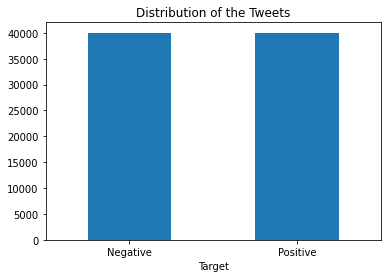

In [10]:
# Plotting the distribution of the dataset in a bar chart.
ax = train_df.groupby('Target').count().plot(kind='bar', title='Distribution of the Tweets',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [11]:
# Storing the data in lists.
target, text = list(train_df['Target']), list(train_df['Text'])

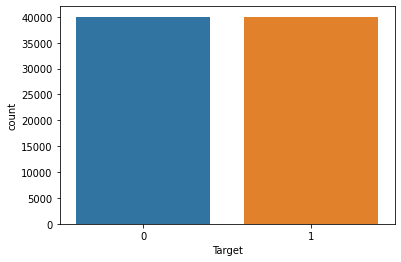

In [12]:
#This displays the distribution of data with count in its y-axis.
sns.countplot(x='Target', data=train_df)

In [13]:
#This is to remove the @user string.
username=['@USER']
#This piece of code was taken from https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in username])
train_df['Text'] = train_df['Text'].apply(lambda text: cleaning_stopwords(text))
train_df['Text'].head()

0    a sicrhau bod mwy o arian poced 'da ti, nes i ...
1    Parti Dolig da gyda tim swyddfa canolog Ty Gwy...
2                       yeaah ma fe yn wir. ( oh well.
3                       hahaha idk. 3am oedd y bws ti?
4                              dwim yn gal llun ohoni?
Name: Text, dtype: object

In [14]:
#This removes all the punctuation present in the dataset.
punct_list=string.punctuation
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punct_list)
    return text.translate(translator)

In [15]:
#List of emoji's.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [16]:
#Data Preprocessing and Stemming
import nltk
import re
from nltk.stem import PorterStemmer
from string import punctuation

porter=PorterStemmer()
def tweet_to_words(tweet):  
   # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    #emove punctuation
    text = re.sub(f"[{re.escape(punctuation)}]", "", tweet)
    # tokenize
    words = text.split()
    # apply stemming
    words = [porter.stem(w) for w in words]
    #remove emoji
    for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji]) 
    # return list
    return words


print("\nOriginal tweet ->", train_df['Text'][0])
print("\nProcessed tweet ->", tweet_to_words(train_df['Text'][0]))


Original tweet -> a sicrhau bod mwy o arian poced 'da ti, nes i fe i ti, Efa, jst i ti never again, creulondeb i ddyffryn Aman!

Processed tweet -> ['a', 'sicrhau', 'bod', 'mwi', 'o', 'arian', 'poce', 'da', 'ti', 'ne', 'i', 'fe', 'i', 'ti', 'efa', 'jst', 'i', 'ti', 'never', 'again', 'creulondeb', 'i', 'ddyffryn', 'aman']


In [17]:
#converting it to a list
X = list(map(tweet_to_words, train_df['Text']))

In [18]:
from sklearn.preprocessing import LabelEncoder
# Encode target labels
le = LabelEncoder()
y = le.fit_transform(train_df['Target'])

In [19]:
#Splitting the dataset into training, testing and validation dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [20]:
#In order to calculate the total vocab size, we are first converting the dataframe to a list and then to a string
words=train_df['Text'].tolist()
word2 = ' '.join([str(element) for element in words]) 

In [21]:
#Finding out the total length of the vocabulary set
length = len(word2)
length

5699868

In [22]:
#CountVectorizer is used to convert a collection of text documents to a vector of term/token counts and enables the ​pre-processing of text data prior to generating the vector representation.
from sklearn.feature_extraction.text import CountVectorizer

vocabulary_size = 500

count_vector = CountVectorizer(max_features=vocabulary_size,
                                ngram_range=(1,2),    
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x) 

# Fitting the training data
X_train = count_vector.fit_transform(X_train).toarray()

# Transforming the testing data
X_test = count_vector.transform(X_test).toarray()


In [23]:
print(count_vector.get_feature_names()[0:5])

['1', '10', '2', '3', '4']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [24]:
#splitting up a larger body of text into smaller lines/words using the Tokenization method

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=100

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforming the text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Padding the sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # returning the sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', train_df['Text'][0])
X, tokenizer = tokenize_pad_sequences(train_df['Text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 a sicrhau bod mwy o arian poced 'da ti, nes i fe i ti, Efa, jst i ti never again, creulondeb i ddyffryn Aman!
After Tokenization & Padding 
 [   3 4314   17  117    4  958  623   11  157    2  158    2   11 1468
    2   11 1413 1612    2    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [25]:
#splitting the sets further again into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [26]:
#Padding the set to produce sequences of the same length
maxlen = 100
X_train_pad = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_train_pad.shape

(51200, 100)

In [27]:
#Implementation of Logistic Regression. Logistic regression estimates the probability of an event occurring, such as voted or didn't vote, based on a given dataset of independent variables
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression()
clf.fit(X_train_pad, y_train)
l_pred=clf.predict(X_test_pad)
#printing the accuracy score of the model
print(accuracy_score(y_test, l_pred))

0.5125625


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [28]:
#implementation of LSTM + Embedding + Sigmoid Classification. LSTM works really well with complex datsets. Here, we have used Sigmoid as the activation function,
#binary_crossentropy as the loss function, adam as the optimiser and accuracy as the measuring metric. We have only given epoch =2 in order to minimise the time and memory usage.

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from keras.layers import Conv1D,GlobalMaxPooling1D,MaxPooling1D 
from keras import regularizers
from keras.layers import Flatten,BatchNormalization,Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras import layers

keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=10, mode='min', min_delta=0.0001),
      ModelCheckpoint('./checkmodel.h5', monitor='val_loss', save_best_only=True, mode='min')
]

vocab_size=5000
maxlen=100
embedding_dim=50


model = Sequential() # create Sequential model
model.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(LSTM(100,dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(1, activation = 'sigmoid')) 
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ['accuracy'])

train_history = model.fit(X_train_pad,y_train, validation_split=0.1, batch_size = 10, epochs = 2, callbacks=keras_callbacks)

Epoch 1/2
4608/4608 [==============================] - 433s 93ms/step - loss: 0.6934 - accuracy: 0.4999 - val_loss: 0.6931 - val_accuracy: 0.5018
Epoch 2/2
4608/4608 [==============================] - 430s 93ms/step - loss: 0.6934 - accuracy: 0.5015 - val_loss: 0.6932 - val_accuracy: 0.5018


In [29]:
pred_model = model.predict(X_test_pad)

In [30]:
#printing the accuracy of the training and the testing set
loss, accuracy = model.evaluate(X_train_pad, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.5020
Testing Accuracy:  0.5004


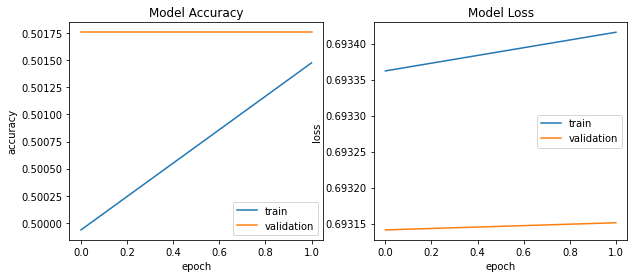

In [31]:
#plotting the history for accuracy and loss.
import matplotlib.pyplot as plt
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(train_history)

In [44]:
def predict_anything_goes(tweet):
  # do something complicated here
  tweet = cleaning_punctuations(tweet)
  tweet = cleaning_stopwords(tweet)
  tweet, tokenizer = tokenize_pad_sequences(tweet)
  y_pred = model.predict(tweet)
  return y_pred.any()

In [36]:
def evaluate():
  total = 0
  correct_from_scratch = 0
  correct_anything_goes = 0
  testfile = open('test.tsv', 'r')
  for line in testfile:
    total += 1
    pieces = line.rstrip("\n").split("\t")
    #if predict_from_scratch(pieces[1]) == int(pieces[0]):
     # correct_from_scratch += 1
    if predict_anything_goes(pieces[1]) == int(pieces[0]):
      correct_anything_goes += 1
  return (correct_from_scratch/total, correct_anything_goes/total)
  

In [45]:
evaluate()

(0.0, 0.4904)